# GenTKG

This notebook aims at re-implementing the GenTKG paper.

Preliminary results are:

- GenTKG validation: 43 / 200 (21 %)
- zrGenTKG-naive validation:
  - 12 / 200 (6 %)
  - 45 / 500 (9 %)
- zrGenTKG-2.0 validation
  - 61 / 500 (12 %)


In [1]:
import nest_asyncio

nest_asyncio.apply()

# Automatically reload modules that have changed
%load_ext autoreload
%autoreload 2

# Load environment variables from .env file
%load_ext dotenv
%dotenv


### 0.1 Understanding the data


In [2]:
import os
import sys
import pandas as pd

# Add the parent directory to the path. This is necessary to be able to import the modules in the parent directory.
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# Refernce the data
DATA_DIR = "./../data/raw"  # Relative path to this Notebook
DATASET = "ICEWS18"

data_folder = os.path.join(DATA_DIR, DATASET)

assert os.path.exists(data_folder), f"Data folder {data_folder} does not exist"
print(f"Data folder: {data_folder}")

# List the files in the data folder
data_files = os.listdir(data_folder)
print(f"Data files: {data_files}")

Data folder: ./../data/raw/ICEWS18
Data files: ['train.txt', 'relation2id.txt', 'get_history_graph.py', 'valid.txt', 'entity2id.txt', 'stat.txt', 'test.txt']


Import train, val and test data


In [4]:
def load_trainvaltest_data(type: str) -> pd.DataFrame:
    _VALID_TYPES = ["train", "valid", "test"]
    assert type in _VALID_TYPES, f"Invalid type {type}. Valid types are {_VALID_TYPES}"

    df = pd.read_csv(
        os.path.join(data_folder, f"{type}.txt"),
        sep="\t",
        dtype=pd.Int16Dtype(),
        dtype_backend="pyarrow",
    )
    df.columns = ["subject_id", "relation_id", "object_id", "timestamp", "_"]
    df = df.drop(columns=["_"])
    return df


# Load the data
df_train = load_trainvaltest_data("train")
df_valid = load_trainvaltest_data("valid")
df_test = load_trainvaltest_data("test")

train_val_split = len(df_valid) / (len(df_valid) + len(df_train))
print(
    f"Train samples: {len(df_train)}, Valid samples: {len(df_valid)} ({round(train_val_split, 2)} %), Test samples: {len(df_test)}"
)

Train samples: 373017, Valid samples: 45994 (0.11 %), Test samples: 49544


Import the decoders


In [5]:
# IMPORT THE DECODERS
# Relation2id
df_relation2id = pd.read_csv(
    os.path.join(data_folder, "relation2id.txt"),
    sep="\t",
    header=None,
    dtype_backend="pyarrow",
)
df_relation2id.columns = ["relation", "relation_id"]
df_relation2id = df_relation2id.astype({"relation_id": pd.Int16Dtype()})

# Entity2id
df_entity2id = pd.read_csv(
    os.path.join(data_folder, "entity2id.txt"),
    sep="\t",
    header=None,
    dtype_backend="pyarrow",
)
df_entity2id.columns = ["entity", "entity_id"]
df_entity2id = df_entity2id.astype({"entity_id": pd.Int16Dtype()})

print(f"Relation2id: {df_relation2id.shape}, Entity2id: {df_entity2id.shape}")
print(df_relation2id.head())
print(df_entity2id.head())

Relation2id: (256, 2), Entity2id: (23033, 2)
                          relation  relation_id
0                   Make statement            0
1        Make an appeal or request            1
2  Use conventional military force            2
3         Rally opposition against            3
4                           Demand            4
                           entity  entity_id
0                     Kim Jong-Un          0
1                     North Korea          1
2   Media Personnel (Afghanistan)          2
3             Media (Afghanistan)          3
4  Islamic Preacher (Afghanistan)          4


Sample a few data points


In [6]:
def decode_data(
    df: pd.DataFrame, relation_decoder: pd.DataFrame, entity_decoder: pd.DataFrame
) -> pd.DataFrame:
    """
    Decodes the data by merging the entity and relation ids with their respective names.
    """
    df_decoded = (
        df.merge(
            entity_decoder.rename(columns={"entity": "subject"}),
            left_on="subject_id",
            right_on="entity_id",
        )
        .drop(columns=["entity_id"])
        .merge(relation_decoder, on="relation_id")
        .merge(
            entity_decoder.rename(columns={"entity": "object"}),
            left_on="object_id",
            right_on="entity_id",
        )
        .drop(columns=["entity_id"])
    )
    return df_decoded


def explain_event(df: pd.DataFrame, idx: int):
    """
    Explains the event at the given index.
    """
    row = df.iloc[idx]
    print_string = f"At timestamp '{row['timestamp']}', '{row['subject']}' '{row['relation']}' '{row['object']}'"
    print(print_string)


df_train_decoded = decode_data(df_train, df_relation2id, df_entity2id)
print(df_train_decoded.head())

# Explain an event
explain_event(df_train_decoded, 0)
explain_event(df_train_decoded, 10)
explain_event(df_train_decoded, 100)

   subject_id  relation_id  object_id  timestamp  \
0           2            0          3          0   
1           4            1          5          0   
2           6            0          7          0   
3           8            2          9          0   
4          10            1          8          0   

                          subject                         relation  \
0   Media Personnel (Afghanistan)                   Make statement   
1  Islamic Preacher (Afghanistan)        Make an appeal or request   
2                  United Nations                   Make statement   
3            Police (Philippines)  Use conventional military force   
4      Philippine National Police        Make an appeal or request   

                  object  
0    Media (Afghanistan)  
1  Citizen (Afghanistan)  
2     Military (Myanmar)  
3  Citizen (Philippines)  
4   Police (Philippines)  
At timestamp '0', 'Media Personnel (Afghanistan)' 'Make statement' 'Media (Afghanistan)'
At timestamp '0

At this stage, it would be interesting to better understand how relations are distributed. For example, is one relation dominating the dataset? Is particular entities dominating specific relations?


In [8]:
df_train_decoded["relation"].unique()

<ArrowExtensionArray>
[                                                   'Make statement',
                                         'Make an appeal or request',
                                   'Use conventional military force',
                                          'Rally opposition against',
                                                            'Demand',
                       'Arrest, detain, or charge with legal action',
                                             'Criticize or denounce',
                                            'Engage in symbolic act',
                                                 'Praise or endorse',
                                       'Expel or deport individuals',
 ...
                                                'Receive inspectors',
                 'Reject request for change in institutions, regime',
                                       'Demand economic cooperation',
                                          'Engage in mass expul

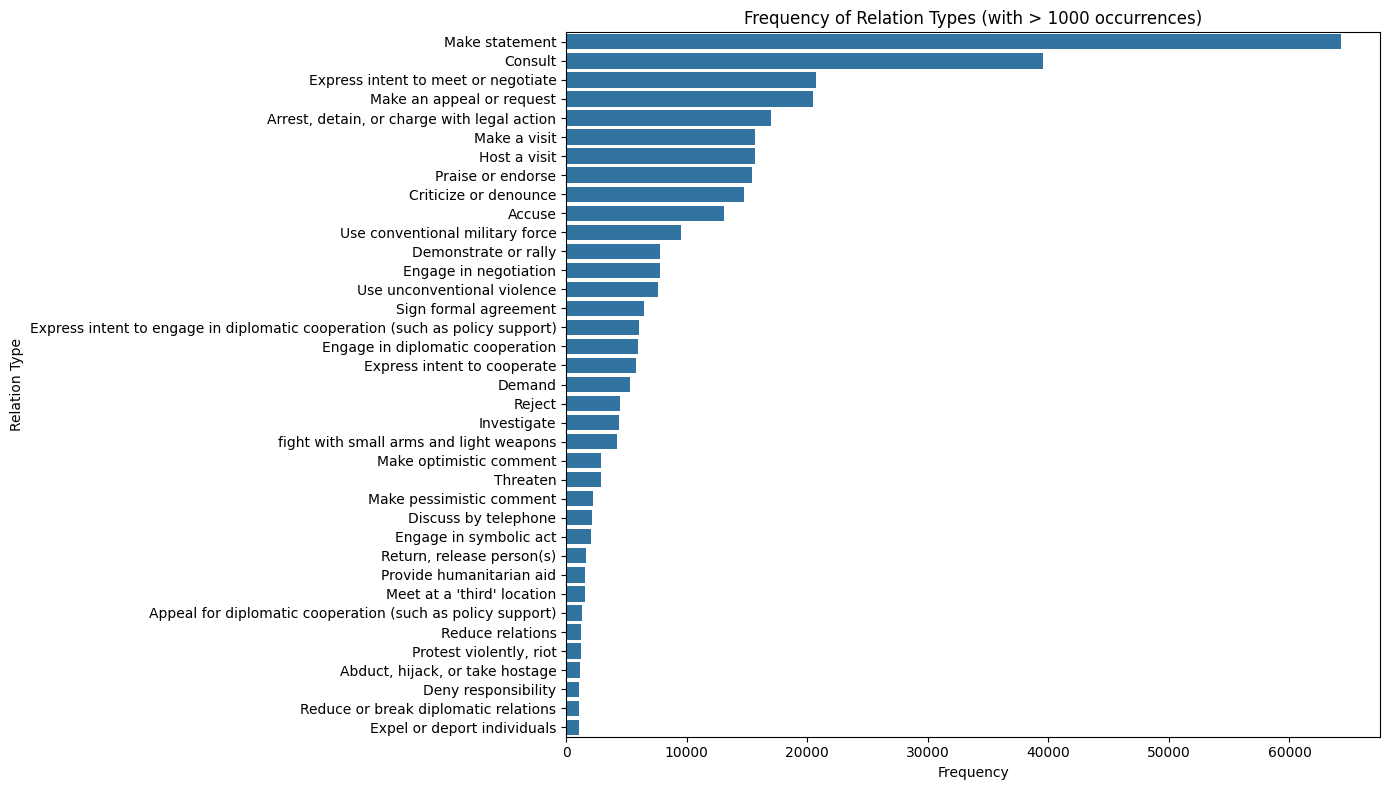

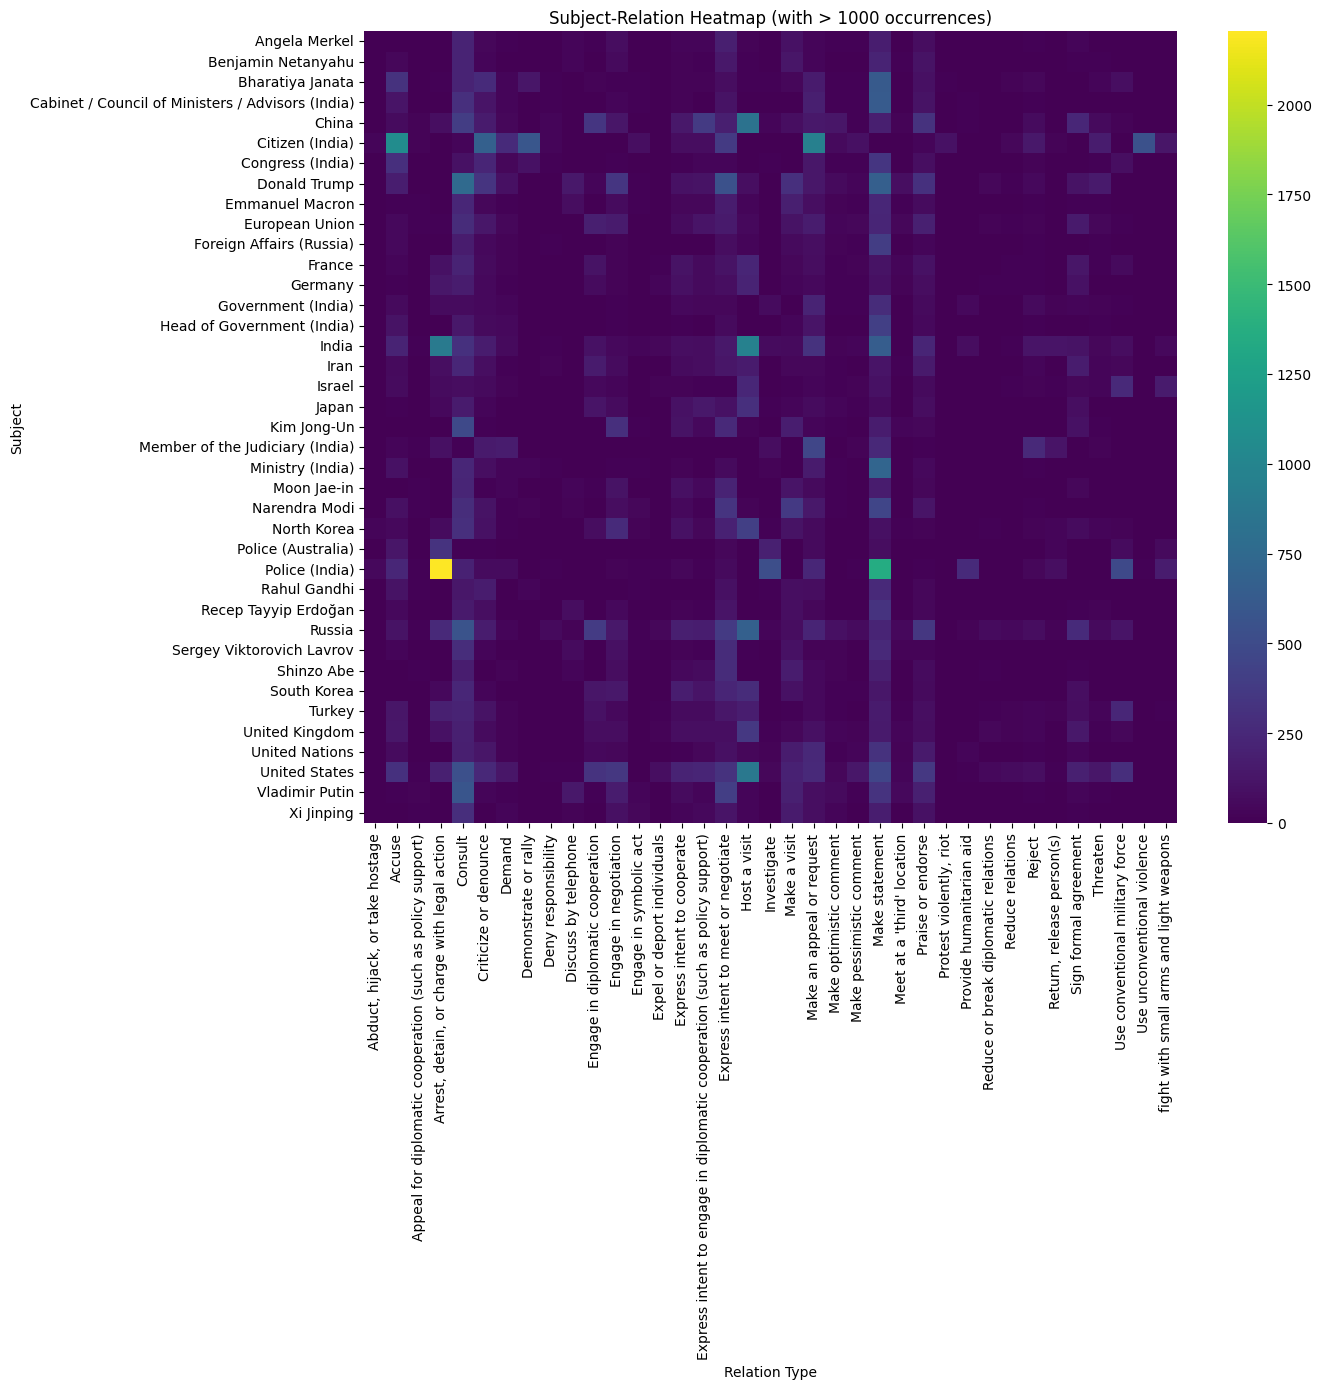

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


def plot_relation_frequency(df):
    """Plot the frequency of relation types with improved label readability."""
    plt.figure(figsize=(14, 8))  # Increase figure size
    relation_counts = df["relation"].value_counts()
    relation_counts = relation_counts[
        relation_counts > 1_000
    ]  # Filter out low-frequency relations

    sns.barplot(x=relation_counts.values, y=relation_counts.index)
    plt.title("Frequency of Relation Types (with > 1000 occurrences)")
    plt.xlabel("Frequency")
    plt.ylabel("Relation Type")
    plt.tight_layout()
    plt.show()


def plot_subject_relation_heatmap(df):
    """Create a heatmap for subject-relation combinations."""
    plt.figure(figsize=(14, 14))  # Increase figure size

    relation_counts = df["relation"].value_counts()
    relation_counts = relation_counts[
        relation_counts > 1_000
    ]  # Filter out low-frequency relations

    subject_relation_counts = (
        df.query(f"relation in {relation_counts.index.tolist()}")
        .groupby(["subject", "relation"])
        .size()
        .unstack(fill_value=0)
    )
    # only keep subjects with more than 10 relations
    subject_relation_counts = subject_relation_counts[
        subject_relation_counts.sum(axis=1) > 1000
    ]
    sns.heatmap(subject_relation_counts, cmap="viridis")

    plt.title("Subject-Relation Heatmap (with > 1000 occurrences)")
    plt.xlabel("Relation Type")
    plt.ylabel("Subject")
    plt.tight_layout()
    plt.show()


plot_relation_frequency(df_train_decoded)
plot_subject_relation_heatmap(df_train_decoded)

### 0.2 GenTKG - Mining Temporal Rules


**Rule Retrieval**


The GenTKGFactsRetriever retriever is the one that was implemented in the GenTKG paper


In [8]:
from project.src.GenTKG.learners.simple_learner import SimpleLearner

# cache_path = "./../cache/temporal_rules_1.json"
cache_path = "./../cache/converted_temporal_rules.json"
learner = SimpleLearner(
    training_data=df_train_decoded,
    cache_path=cache_path,
)
learner.learn()

Temporal rules loaded from cache: ./../cache/converted_temporal_rules.json


In [9]:
from project.src.GenTKG.models import TKGQuery
from project.src.GenTKG.retrievers.gen_tkg_retriever import GenTKGFactsRetriever

gentkg_retriever = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_train_decoded,
    learner=learner,
)

facts_test = gentkg_retriever.retrieve_facts(
    TKGQuery(
        timestamp=24 * 30 * 3,
        subject_id=6,
        subject="Abdulrahman",
        relation_id=1,
        relation="Make an appeal or request",
    ),
    verbose=True,
)

Retrieved 267 facts in the time window.
Retrieved 24 facts based on the rule head.
Found 42 relevant temporal rules to the head.
Retrieved 26 facts based on the rule body.


### 0.3 Try some queries


Define supporting classes, e.g LLMs


In [10]:
from typing import List
from openai import OpenAI, AsyncOpenAI
import re
from pydantic import BaseModel, Field
from project.src.GenTKG.models import TKGFact
from project.src.GenTKG.retrievers.interface import IFactsRetriever

INSTRUCTION = """
You must be able to correctly predict the next {object_label} from a given text consisting of multiple quadruplets in the form of "[{time}]:[{subject}, {relation}, {object_label}.{object}]" and the query in the form of "[{time}]:[{subject}, {relation}," in the end. The quadruples represents the relevant historical events leading up to today. You must generate only the single number for {object_label} without any explanation.
"""
MODEL = "gpt-4o-mini"


class GenTKGModel:
    def __init__(
        self,
        api_key: str,
        model: str,
        instructions: str = INSTRUCTION,
        retriever: IFactsRetriever = None,
    ):
        self.model = model
        self.instructions = instructions
        self.retriever = retriever

        self.client = OpenAI(api_key=api_key)
        self.aclient = AsyncOpenAI(api_key=api_key)

    # We can now use the client to interact with the OpenAI API
    def prompt(self, query: TKGQuery, verbose: bool = False) -> int:
        facts = self.retriever.retrieve_facts(query)
        latest_time = query.timestamp

        # formatted_rules = "\n".join([str(rule) for rule in rules])
        formatted_history = "\n".join(
            [fact.to_relative_string(latest_time) for fact in facts]
        )
        # formatted_query = str(query)
        formatted_query = query.to_relative_string(latest_time)
        input = f"{formatted_history}\n{formatted_query}"

        if verbose:
            print(f"Input: {input} \n --------")

        response = self.client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": self.instructions,
                },
                {
                    "role": "user",
                    "content": input,
                },
            ],
            model=self.model,
        )
        object_id_str = response.choices[0].message.content

        if verbose:
            print(f"Output: {object_id_str}")

        try:
            object_id = int(re.findall(r"\d+", object_id_str)[0])
        except IndexError:
            print(f"Error: Could not convert '{object_id_str}' to integer")
            object_id = None

        return object_id

    async def prompt_structured(
        self, query: TKGQuery, schema: BaseModel, verbose: bool = False
    ) -> BaseModel:
        facts = self.retriever.retrieve_facts(query, verbose=verbose)
        latest_time = query.timestamp

        # formatted_rules = "\n".join([str(rule) for rule in rules])
        formatted_history = "\n".join(
            [fact.to_relative_string(latest_time) for fact in facts]
        )
        # formatted_query = str(query)
        formatted_query = query.to_relative_string(latest_time)
        input = f"{formatted_history}\n{formatted_query}"

        if verbose:
            print(f"Input: {input} \n --------")

        response = await self.aclient.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": self.instructions,
                },
                {
                    "role": "user",
                    "content": input,
                },
            ],
            model=self.model,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "StructuredResponse",
                    "schema": schema.model_json_schema(),
                },
            },
        )

        json_response = response.choices[0].message.content
        pasrsed_data = schema.model_validate_json(json_response)
        return pasrsed_data

Instantiate retreivers


In [11]:
# Instantiate retrievers
from project.src.GenTKG.retrievers.example_fact_retriever import ExampleFactsRetriever
from project.src.GenTKG.retrievers.naive_facts_retriever import NaiveFactsRetriever


example_facts_retriever = ExampleFactsRetriever()
naive_facts_retriever = NaiveFactsRetriever(
    training_data=df_train_decoded, w=24 * 365, N=50
)

# cache_path = "./../cache/temporal_rules_1.json"

gentkg_retriever = GenTKGFactsRetriever(
    w=24 * 30,
    N=50,
    retrieval_data=df_train_decoded,
    learner=learner,
)

Construct evaluation functions


In [12]:
from pydantic import BaseModel, Field
from typing import List, Tuple, Union


class Answer(BaseModel):
    rank: int
    object_id: Union[int, None] = Field(
        None, title="Object ID. None if not available, or alternatives exhausted"
    )


class ResponseModel(BaseModel):
    answers: List[Answer] = Field(
        ..., title="List of answers, ranked from 1 to N with 1 being the top answer"
    )


class EvaluateResponseModel(BaseModel):
    true: List[int] = Field(..., title="The true object IDs")
    predicted: ResponseModel = Field(..., title="The predicted response")


def print_ranked_response(response: ResponseModel):
    # print(f"Rank 1 Motivation: {response.motivation}")
    print(f"Full ranking:")
    for answer in response.answers:
        print(f"Rank {answer.rank}: {answer.object_id}")


def compute_hits_at_k(
    evaluation: List[EvaluateResponseModel], k: int
) -> Tuple[float, float]:
    """
    Computes the mean and standard deviation of the hits at k.

    The standard deviation is computed as:
    std = p(1 - p) / N
    where p is the mean and N is the number of samples.

    This is because the hits at k is a binomial distribution, and the standard deviation of a binomial distribution is
    p(1 - p) / N.
    """

    hits = 0
    for eval in evaluation:
        true = eval.true
        predicted = eval.predicted.answers[:k]
        predicted_ids = [answer.object_id for answer in predicted]
        if any([pred_id in true for pred_id in predicted_ids]):
            hits += 1

    mean = hits / len(evaluation)
    std = (mean * (1 - mean)) / len(evaluation)
    return mean, std


evaluation_test_data = [
    EvaluateResponseModel(
        true=[1],
        predicted=ResponseModel(
            answers=[
                Answer(rank=1, object_id=1, object_label="label1"),
                Answer(rank=2, object_id=2, object_label="label2"),
                Answer(rank=3, object_id=3, object_label="label3"),
            ],
            motivation="Motivation for the ranked 1 answer",
        ),
    ),
    EvaluateResponseModel(
        true=[2, 11],
        predicted=ResponseModel(
            answers=[
                Answer(rank=2, object_id=1, object_label="label1"),
                Answer(rank=3, object_id=3, object_label="label3"),
                Answer(rank=1, object_id=2, object_label="label2"),
            ],
            motivation="Motivation for the ranked 1 answer",
        ),
    ),
]

assert compute_hits_at_k(evaluation_test_data, 1)[0] == 0.5
assert (
    compute_hits_at_k(evaluation_test_data, 3)[0] == 1.0
), f"Expected 1.0, got {compute_hits_at_k(evaluation_test_data, 3)}"
assert compute_hits_at_k(evaluation_test_data, 5)[0] == 1.0

In [13]:
query = TKGQuery(
    timestamp=5040,
    subject_id=1823,
    subject="Rami Abdulrahman",
    relation_id=8,
    relation="Praise or endorse",
)

# Now give it a try with the paper's example
instructions_modified = INSTRUCTION + "\n\n Please give 10 answers."
print(instructions_modified)

model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever,
)

# output_id = model.prompt(query, verbose=True)
output = await model.prompt_structured(query, schema=ResponseModel, verbose=True)


You must be able to correctly predict the next {object_label} from a given text consisting of multiple quadruplets in the form of "[{time}]:[{subject}, {relation}, {object_label}.{object}]" and the query in the form of "[{time}]:[{subject}, {relation}," in the end. The quadruples represents the relevant historical events leading up to today. You must generate only the single number for {object_label} without any explanation.


 Please give 10 answers.


### 0.4 Test the setup


In [14]:
# Hyperparameters
class Hyperparameters(BaseModel):
    N: int = 50
    w: int = 24 * 30 * 3


hp = Hyperparameters(N=50, w=24 * 30 * 3)

In [15]:
from typing import Tuple


df_valid_decoded = decode_data(df_valid, df_relation2id, df_entity2id)
df_test_decoded = decode_data(df_test, df_relation2id, df_entity2id)


def sample_query(
    df_decoded: pd.DataFrame, cutoff_timestamp: int = 0
) -> Tuple[TKGQuery, List[TKGFact]]:
    """
    Samples a random query from the decoded DataFrame.

    Parameters:
    - df_decoded: The decoded DataFrame. Must contain columns 'timestamp', 'subject_id', 'subject', 'relation_id', 'relation'
    - cutoff_timestamp: The minimum timestamp to sample from

    Returns:
    - TKGQuery: The sampled query
    - TKGFact[]: The corresponding facts with the same subject, relation and time. Predicting anyone of these facts is considered correct.
    """
    row = df_decoded.query("timestamp >= @cutoff_timestamp").sample(1).iloc[0]
    query = TKGQuery(
        timestamp=row["timestamp"],
        subject_id=row["subject_id"],
        subject=row["subject"],
        relation_id=row["relation_id"],
        relation=row["relation"],
    )

    subject_id = query.subject_id
    relation_id = query.relation_id
    timestamp = query.timestamp

    # Get the facts at the timestamp
    df_correct_facts = df_decoded.query(
        f"timestamp == {timestamp} and subject_id == {subject_id} and relation_id == {relation_id}"
    ).to_dict(orient="records")

    facts = [
        TKGFact(
            timestamp=row["timestamp"],
            subject=row["subject"],
            relation=row["relation"],
            object=row["object"],
            object_id=row["object_id"],
        )
        for row in df_correct_facts
    ]

    return query, facts


query, facts = sample_query(df_train_decoded)
print("QUERY:", query)
print("FACTS:", facts)

QUERY: 2760:[Kim Jong-Un, Express intent to meet or negotiate,
FACTS: [TKGFact(timestamp=2760, subject='Kim Jong-Un', relation='Express intent to meet or negotiate', object='Moon Jae-in', object_id=157), TKGFact(timestamp=2760, subject='Kim Jong-Un', relation='Express intent to meet or negotiate', object='Head of Government (South Korea)', object_id=474), TKGFact(timestamp=2760, subject='Kim Jong-Un', relation='Express intent to meet or negotiate', object='Head of Government (United States)', object_id=373), TKGFact(timestamp=2760, subject='Kim Jong-Un', relation='Express intent to meet or negotiate', object='Donald Trump', object_id=80)]


Test the predictions


In [16]:
import os
from typing import Callable
import asyncio


def label_is_inn_supporting_facts(
    supporting_facts: List[TKGFact], facts: List[TKGFact]
):
    supporting_fact_object_ids = [fact.object_id for fact in supporting_facts]
    correct_object_ids = [fact.object_id for fact in facts]

    possible = any(
        output_id in correct_object_ids for output_id in supporting_fact_object_ids
    )

    if not possible:
        print(
            f"Warning: The supporting facts ({len(supporting_facts)}) do not contain any true object_ids {correct_object_ids}. The model could not have been correct for the query on fact {facts}."
        )
        return False

    return True


async def evaluate_one_sample(
    model: GenTKGModel, data_generator: Callable, verbose: bool = False
) -> EvaluateResponseModel | None:
    query, facts = data_generator()

    try:
        response_model = await model.prompt_structured(
            query=query, schema=ResponseModel, verbose=verbose
        )
    except Exception as e:
        return None

    correct_object_ids = [fact.object_id for fact in facts]

    evaluate_response_model = EvaluateResponseModel(
        true=correct_object_ids, predicted=response_model
    )
    return evaluate_response_model


async def evaluate_model_asyncio(
    model: GenTKGModel, data_generator: Callable, n: int = 10, verbose: bool = False
) -> List[EvaluateResponseModel]:
    """
    Evaluate the model asynchronously using asyncio, and return the results.
    """
    print(f"Running {n} samples")

    # Split the tasks in batches of at max 50
    BATCH_SIZE = 50
    n_of_batches = n // BATCH_SIZE + 1

    results = []
    for batch in range(n_of_batches):
        print(f"Running batch {batch+1}/{n_of_batches}")

        # Check if we are at the last batch, then ensure we dont overflow
        if batch == n_of_batches - 1:
            BATCH_SIZE = n % BATCH_SIZE
        tasks = [
            evaluate_one_sample(model, data_generator, verbose)
            for _ in range(BATCH_SIZE)
        ]
        batch_results = await asyncio.gather(*tasks)

        # Remove None values
        batch_results = [result for result in batch_results if result is not None]
        results.extend(batch_results)

    return results


# The retrieval data is the training and validation data combined, which is where the retriever will look for facts.
df_trainval_decoded = (
    pd.concat([df_train_decoded, df_valid_decoded, df_test_decoded], axis=0)
    .reset_index(drop=True)
    .sort_values("timestamp", ascending=True)
)
# Only keep entities that are in our evaluation set
eval_entities = set(df_test["subject_id"]).union(set(df_test["object_id"]))
df_trainval_decoded = df_trainval_decoded[
    df_trainval_decoded["subject_id"].isin(eval_entities)
    | df_trainval_decoded["object_id"].isin(eval_entities)
]

cutoff_timestamp = df_test_decoded[
    "timestamp"
].min()  # The minimum timestamp in the validation set

# Setup everything and run!
cache_path = "./../cache/converted_temporal_rules.json"
learner = SimpleLearner(
    training_data=df_trainval_decoded,
    cache_path=cache_path,
)
gentkg_retriever_validation = GenTKGFactsRetriever(
    w=hp.w,
    N=hp.N,
    retrieval_data=df_trainval_decoded,
    learner=learner,
)
# Instantiate the retriever and model as before
model = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_validation,
)

data_generator = lambda: sample_query(
    df_trainval_decoded, cutoff_timestamp=cutoff_timestamp
)

Attempting to get_rules without learning first. Learning now...
Temporal rules loaded from cache: ./../cache/converted_temporal_rules.json


In [24]:
# Run the evaluation in parallel
evalute_response = asyncio.run(evaluate_model_asyncio(model, data_generator, n=2_000))

Running 2000 samples
Running batch 1/41
Running batch 2/41
Running batch 3/41
Running batch 4/41
Running batch 5/41
Running batch 6/41
Running batch 7/41
Running batch 8/41
Running batch 9/41
Running batch 10/41
Running batch 11/41
Running batch 12/41
Running batch 13/41
Running batch 14/41
Running batch 15/41
Running batch 16/41
Running batch 17/41
Running batch 18/41
Running batch 19/41
Running batch 20/41
Running batch 21/41
Running batch 22/41
Running batch 23/41
Running batch 24/41
Running batch 25/41
Running batch 26/41
Running batch 27/41
Running batch 28/41
Running batch 29/41
Running batch 30/41
Running batch 31/41
Running batch 32/41
Running batch 33/41
Running batch 34/41
Running batch 35/41
Running batch 36/41
Running batch 37/41
Running batch 38/41
Running batch 39/41
Running batch 40/41
Running batch 41/41


In [18]:
import random


def visualize_bootstrapped_hits_at_k(
    evaluation: List[EvaluateResponseModel],
    k: List[int] = [1, 3, 5, 10],
    interval_size: int = 20,
):
    """
    Visualize Bootsrapped Hits@K.

    This function slices the dataset into sample_size number of samples and computes the Hits@K for the first sample, then the first two samples, and so on.
    This is done for each value of k in the list k. The results are then visualized as a line plot.
    """
    if len(evaluation) == 0:
        print("No evaluation data to visualize")
        return
    hits_at_k = {k_val: [] for k_val in k}
    hits_at_k_std = {k_val: [] for k_val in k}
    evaluation_shuffled = evaluation.copy()
    random.shuffle(evaluation_shuffled)

    for i in range(interval_size, len(evaluation_shuffled) + 1, interval_size):
        sliced_evaluation = evaluation_shuffled[:i]
        for k_val in k:
            mean, std = compute_hits_at_k(sliced_evaluation, k_val)
            hits_at_k[k_val].append(mean)
            hits_at_k_std[k_val].append(std)

    # Compute the remaining set of samples if needed
    has_remaining = len(evaluation_shuffled) % interval_size != 0
    if has_remaining:
        sliced_evaluation = evaluation_shuffled
        for k_val in k:
            mean, std = compute_hits_at_k(sliced_evaluation, k_val)
            hits_at_k[k_val].append(mean)
            hits_at_k_std[k_val].append(std)

    plt.figure(figsize=(10, 7))
    linestyles = ["-", "--", "-.", ":", "-"]
    for idx, k_val in enumerate(k):
        linestyle = linestyles[idx % len(linestyles)]
        label = f"Hits@{k_val} {hits_at_k[k_val][-1]:.2f}"

        x = list(range(interval_size, len(evaluation_shuffled) + 1, interval_size))
        if has_remaining:
            x.append(len(evaluation_shuffled))
        plt.plot(x, hits_at_k[k_val], label=label, linestyle=linestyle, marker="o")

    plt.xlabel("Cumulative Number of Samples")
    plt.ylabel("Hits@K")
    plt.title("Cumulative Bootstrapped Hits@K")
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


visualize_bootstrapped_hits_at_k(evalute_response)

## 0.5 Explore zero-shot relations


To improve our model to handle zero-shot relations, we want to evaluate how well the model is able to predict what happens on relations it hasn't seen before.

This is achieved by hiding categories from the training data, and let the model predict those samples only during the evaluation. One can choose to either hide relations or objects. Previous papers (e.g. zrLLM) hid relations which we'll do here as well. It makes the most sense.

**Plan**

1. First we will decide on which relations to hide.
2. Omit these from the training data.
3. Learn the rules like before, but this time with the altered training data.
4. Perform the evaluation, but query only on zero-shot relations.


**[1] Hide relations**

In zrLLM, they drew a threshold of relation frequency, and all relations with less than that became zero-shot.


In [50]:
THRESHOLD = 40  # Set a threshold for the number of occurrences


def extract_zr_ids(df: pd.DataFrame, threshold: int) -> List[str]:
    """
    Extracts the zero-shot relations from the DataFrame.
    """
    df_relation_freq = df.groupby("relation_id").size().sort_values(ascending=False)
    df_zero_shot_relations = df_relation_freq[df_relation_freq <= threshold]
    return df_zero_shot_relations.index


zr_relation_ids = extract_zr_ids(df_train_decoded, THRESHOLD)

**[2] Omit these from the training data**


Number of zero-shot relations: 93 (251 unique relations)
Percentage of rows left after removing zero-shot relations: 99.65%


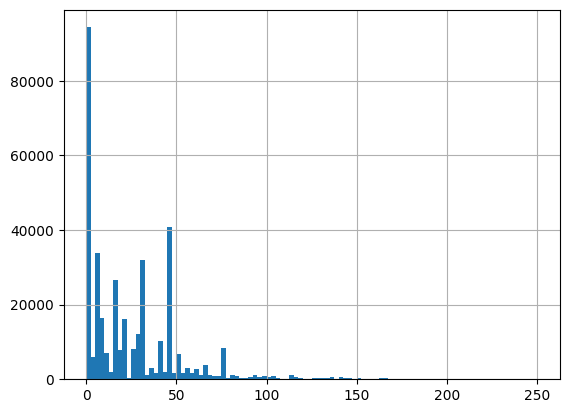

In [51]:
df_train_decoded_no_zr = df_train_decoded.query("relation_id not in @zr_relation_ids")

assert len(df_train_decoded_no_zr) < len(
    df_train_decoded
), "No zero-shot relations removed"
assert (
    df_train_decoded_no_zr["relation_id"].isin(zr_relation_ids).sum() == 0
), "Zero-shot relations still present"

# Plot the distribution of relation types, and other metrics
df_train_decoded.relation_id.hist(bins=100)
print(
    f"Number of zero-shot relations: {len(zr_relation_ids)} ({len(df_train_decoded.relation_id.unique())} unique relations)"
)
print(
    f"Percentage of rows left after removing zero-shot relations: {len(df_train_decoded_no_zr) / len(df_train_decoded) * 100:.2f}%"
)

**[3] Learn the temporal rules wrt zero-shot**

Here, we simply take the original learner and omit any rule that references one of the zero-shot relations.


In [52]:
cache_path_zr = "./../cache/converted_temporal_rules.json"


learner_zr = SimpleLearner(
    training_data=pd.DataFrame(),
    cache_path=cache_path_zr,
)

learner_zr.learn()
learner_zr.remove_rules(relation_ids=zr_relation_ids)

Temporal rules loaded from cache: ./../cache/converted_temporal_rules.json
Removed 930 rules.


**[4a] Perform the zero-shot evaluation - NAIVELY**


In [53]:
# Now, we must filter the validation data to only contain zero-shot relations.
# This is where the data sampler will draw queries from
df_test_decoded_zr = df_test_decoded.query("relation_id in @zr_relation_ids")

assert df_test_decoded_zr["relation_id"].isin(zr_relation_ids).sum() == len(
    df_test_decoded_zr
), "Not all zero-shot relations present"

# Then, we must also remove any zero-shot relations from the training data. This is where the retriever will look for facts.
df_trainval_decoded_no_zr = df_trainval_decoded.query(
    "relation_id not in @zr_relation_ids"
)

assert (
    df_trainval_decoded_no_zr["relation_id"].isin(zr_relation_ids).sum() == 0
), "Zero-shot relations still present"

In [54]:
# The retriever can only retrieve facts with zero-shot relations.
gentkg_retriever_zr = GenTKGFactsRetriever(
    w=hp.w,
    N=hp.N,
    retrieval_data=df_trainval_decoded_no_zr,
    learner=learner_zr,
)

# Instantiate the retriever and model as before
model_zr = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_zr,
)

# Run the evaluation in parallel
cutoff_timestamp = df_test_decoded[
    "timestamp"
].min()  # The minimum timestamp in the validation set

data_generator_zr = lambda: sample_query(
    df_test_decoded_zr, cutoff_timestamp=cutoff_timestamp
)

In [42]:
# Run the evaluation in parallel
evalute_response_zr = asyncio.run(
    evaluate_model_asyncio(model_zr, data_generator_zr, n=1_000, verbose=False)
)

Running 1000 samples
Running batch 1/21
Running batch 2/21
Running batch 3/21
Running batch 4/21
Running batch 5/21
Running batch 6/21
Running batch 7/21
Running batch 8/21
Running batch 9/21
Running batch 10/21
Running batch 11/21
Running batch 12/21
Running batch 13/21
Running batch 14/21
Running batch 15/21
Running batch 16/21
Running batch 17/21
Running batch 18/21
Running batch 19/21
Running batch 20/21
Running batch 21/21


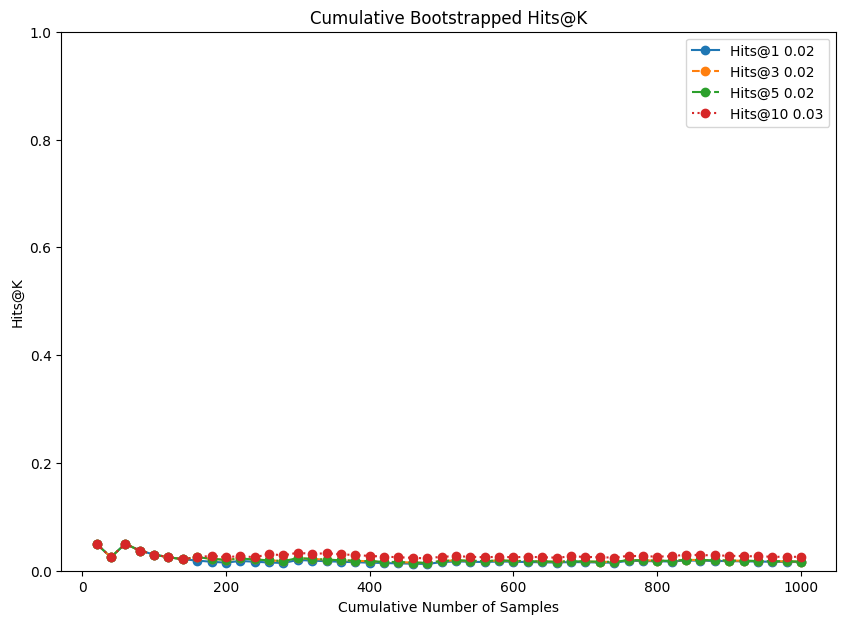

In [43]:
visualize_bootstrapped_hits_at_k(evalute_response_zr)

As can be seen, the model is only able to fetch facts which has the zero-shot relation. It is not able to fetch any other facts, simply because it hasn't learnt any rules for that. There probably are a lot of rules that are applicable, but the model has no way of knowing what to use.


**[4b] Perform the zero-shot evaluation - EXTENDED**

Now, it's time to actually extend our model to handle zero-shot relations. To do that we need to fill our vector store.


In [55]:
from project.src.GenTKG.vectorstore import SimpleVectorstore
from project.src.GenTKG.vectorstore import FaissVectorstore

""" 
cache_path_vector_store = "./../cache/vectorstore.json"

vectorstore = SimpleVectorstore(
    cache_path=cache_path_vector_store,
    openai_api_key=os.environ.get("OPENAI_API_KEY"),
) 
"""

cache_path_vector_store_faiss = "./../cache/vectorstore_faiss.json"
vectorstore = FaissVectorstore(
    cache_path=cache_path_vector_store_faiss,
    openai_api_key=os.environ.get("OPENAI_API_KEY"),
)


all_relations = df_train_decoded["relation"].unique()
vectorstore.insert(all_relations)
vectorstore.update_cache()

No new relations to insert


In [56]:
# Exapmle of how to retrieve vectors
relation_zero_shot = "Send an invoice"
similar_relations = vectorstore.get_topk_similar(relation_zero_shot, k=3)

print(f"Similar relations to '{relation_zero_shot}': {similar_relations}")

Similar relations to 'Send an invoice': ['Receive inspectors', 'Make an appeal or request', 'Host a visit']


In [57]:
from project.src.GenTKG.retrievers.gen_tkg_zr_retriever import (
    GenTKGZeroShotFactsRetriever,
)

gentkg_retriever_zr_extended = GenTKGZeroShotFactsRetriever(
    w=hp.w,
    N=hp.N,
    retrieval_data=df_trainval_decoded_no_zr,
    learner=learner_zr,
    vectorstore=vectorstore,
)

In [58]:
# EXAMPLE:
# Here, we create a "fake" query with a completetly unreasonable relation, to see what the retriever returns.

query = TKGQuery(
    timestamp=6458,
    subject_id=13,
    subject="Rodrigo Duterte",
    relation_id=999,
    relation="Wanting to kill",
)

facts_test = gentkg_retriever_zr_extended.retrieve_facts(
    query, verbose=True
)

Retrieved 271 facts in the time window.
Retrieved 0 facts based on the rule head.
Found 0 relevant temporal rules to the query.
Found 49 top-k similar temporal rules.
Retrieved 50 facts based on the rule body.


Good! Now lets redo the previous zero-shot evaluation


In [59]:
# Instantiate the retriever and model as before
model_zr_extended = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=gentkg_retriever_zr_extended,
)

# Run the evaluation in parallel
cutoff_timestamp = df_test_decoded[
    "timestamp"
].min()  # The minimum timestamp in the validation set

data_generator_zr = lambda: sample_query(
    df_test_decoded_zr, cutoff_timestamp=cutoff_timestamp
)

In [35]:
# Run the evaluation in parallel
evalute_response_zr_extended = asyncio.run(
    evaluate_model_asyncio(model_zr_extended, data_generator_zr, n=2_000, verbose=False)
)

Running 2000 samples
Running batch 1/41
Running batch 2/41
Running batch 3/41
Running batch 4/41
Running batch 5/41
Running batch 6/41
Running batch 7/41
Running batch 8/41
Running batch 9/41
Running batch 10/41
Running batch 11/41
Running batch 12/41
Running batch 13/41
Running batch 14/41
Running batch 15/41
Running batch 16/41
Running batch 17/41
Running batch 18/41
Running batch 19/41
Running batch 20/41
Running batch 21/41
Running batch 22/41
Running batch 23/41
Running batch 24/41
Running batch 25/41
Running batch 26/41
Running batch 27/41
Running batch 28/41
Running batch 29/41
Running batch 30/41
Running batch 31/41
Running batch 32/41
Running batch 33/41
Running batch 34/41
Running batch 35/41
Running batch 36/41
Running batch 37/41
Running batch 38/41
Running batch 39/41
Running batch 40/41
Running batch 41/41


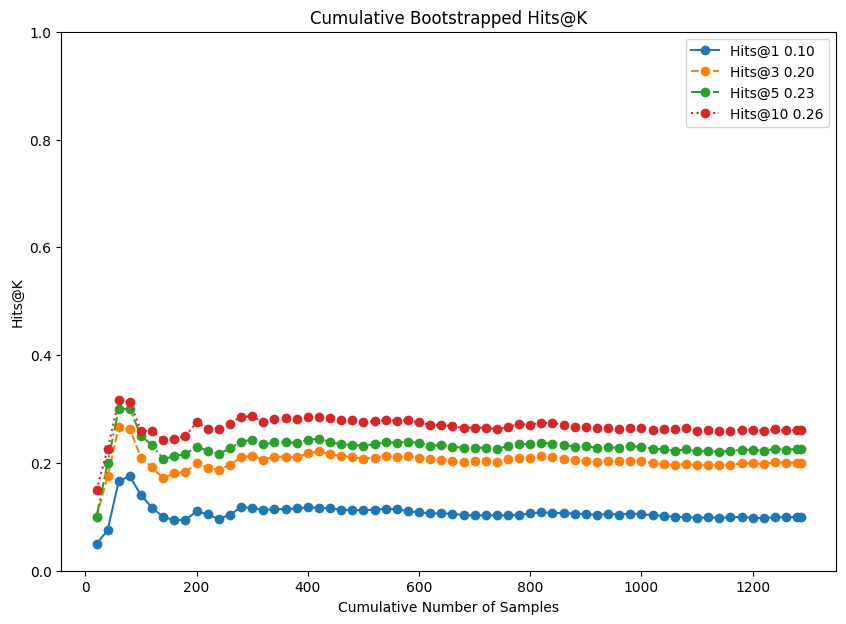

In [36]:
visualize_bootstrapped_hits_at_k(evalute_response_zr_extended)


# Extra
## Naive Implementation

AKA just pull last 50

**1) Base Case**

In [39]:
# The retrieval data is the training and validation data combined, which is where the retriever will look for facts.
df_trainval_decoded = (
    pd.concat([df_train_decoded, df_valid_decoded, df_test_decoded], axis=0)
    .reset_index(drop=True)
    .sort_values("timestamp", ascending=True)
)
# Only keep entities that are in our evaluation set
eval_entities = set(df_test["subject_id"]).union(set(df_test["object_id"]))
df_trainval_decoded = df_trainval_decoded[
    df_trainval_decoded["subject_id"].isin(eval_entities)
    | df_trainval_decoded["object_id"].isin(eval_entities)
]

cutoff_timestamp = df_test_decoded[
    "timestamp"
].min()  # The minimum timestamp in the validation set

# Setup everything and run!
retriever_naive = NaiveFactsRetriever(training_data=df_trainval_decoded, w=hp.w, N=hp.N)

# Instantiate the retriever and model as before
model_naive = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=retriever_naive,
)

data_generator = lambda: sample_query(
    df_trainval_decoded, cutoff_timestamp=cutoff_timestamp
)

In [43]:
# Run the evaluation in parallel
evalute_response_naive = asyncio.run(
    evaluate_model_asyncio(model_naive, data_generator, n=2_000, verbose=False)
)

Running 2000 samples
Running batch 1/41
Running batch 2/41
Running batch 3/41
Running batch 4/41
Running batch 5/41
Running batch 6/41
Running batch 7/41
Running batch 8/41
Running batch 9/41
Running batch 10/41
Running batch 11/41
Running batch 12/41
Running batch 13/41
Running batch 14/41
Running batch 15/41
Running batch 16/41
Running batch 17/41
Running batch 18/41
Running batch 19/41
Running batch 20/41
Running batch 21/41
Running batch 22/41
Running batch 23/41
Running batch 24/41
Running batch 25/41
Running batch 26/41
Running batch 27/41
Running batch 28/41
Running batch 29/41
Running batch 30/41
Running batch 31/41
Running batch 32/41
Running batch 33/41
Running batch 34/41
Running batch 35/41
Running batch 36/41
Running batch 37/41
Running batch 38/41
Running batch 39/41
Running batch 40/41
Running batch 41/41


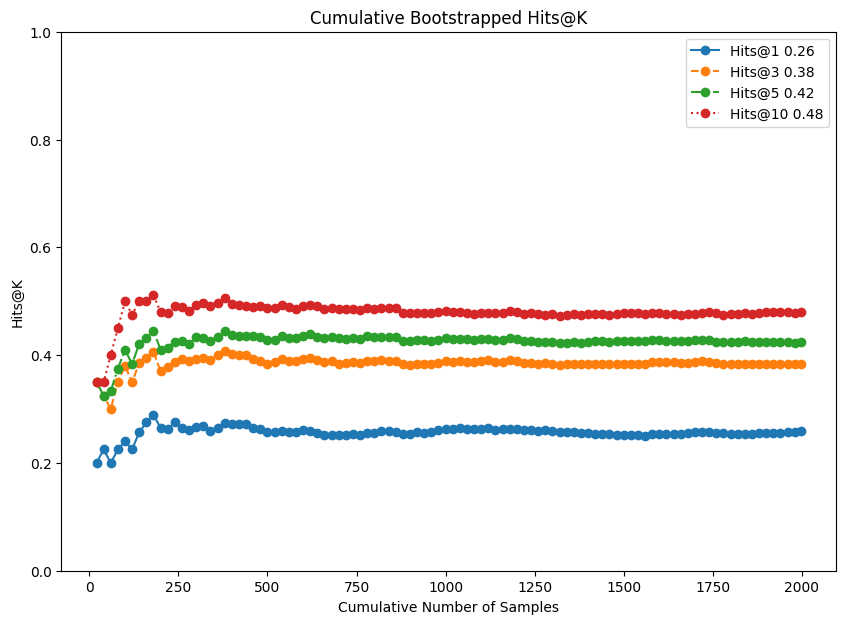

In [44]:
visualize_bootstrapped_hits_at_k(evalute_response_naive)

**B) Zero shot case**

In [49]:
assert False, "Have you run the evaluation for the zero-shot relations?"

AssertionError: Have you run the evaluation for the zero-shot relations?

In [60]:
retriever_naive_zr = NaiveFactsRetriever(
    training_data=df_trainval_decoded_no_zr, w=hp.w, N=hp.N
)

# Instantiate the retriever and model as before
model_zr_naive = GenTKGModel(
    api_key=os.environ.get("OPENAI_API_KEY"),
    model=MODEL,
    instructions=instructions_modified,
    retriever=retriever_naive_zr,
)

# Run the evaluation in parallel
cutoff_timestamp = df_test_decoded[
    "timestamp"
].min()  # The minimum timestamp in the validation set

data_generator_zr = lambda: sample_query(
    df_test_decoded_zr, cutoff_timestamp=cutoff_timestamp
)

In [63]:
# Run the evaluation in parallel
evalute_response_zr_naive = asyncio.run(
    evaluate_model_asyncio(model_zr_naive, data_generator_zr, n=2_500, verbose=False)
)

Running 2500 samples
Running batch 1/51
Running batch 2/51
Running batch 3/51
Running batch 4/51
Running batch 5/51
Running batch 6/51
Running batch 7/51
Running batch 8/51
Running batch 9/51
Running batch 10/51
Running batch 11/51
Running batch 12/51
Running batch 13/51
Running batch 14/51
Running batch 15/51
Running batch 16/51
Running batch 17/51
Running batch 18/51
Running batch 19/51
Running batch 20/51
Running batch 21/51
Running batch 22/51
Running batch 23/51
Running batch 24/51
Running batch 25/51
Running batch 26/51
Running batch 27/51
Running batch 28/51
Running batch 29/51
Running batch 30/51
Running batch 31/51
Running batch 32/51
Running batch 33/51
Running batch 34/51
Running batch 35/51
Running batch 36/51
Running batch 37/51
Running batch 38/51
Running batch 39/51
Running batch 40/51
Running batch 41/51
Running batch 42/51
Running batch 43/51
Running batch 44/51
Running batch 45/51
Running batch 46/51
Running batch 47/51
Running batch 48/51
Running batch 49/51
Running 

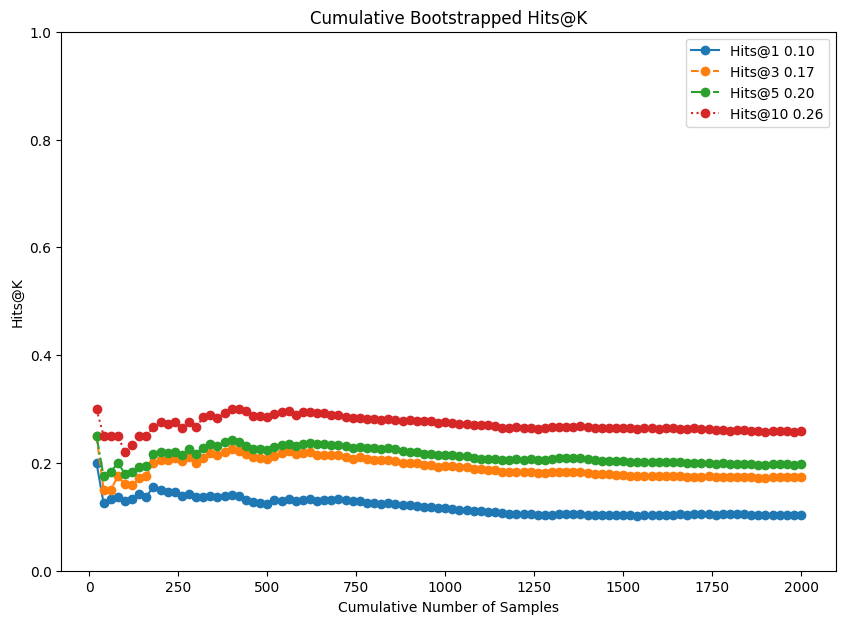

In [62]:
visualize_bootstrapped_hits_at_k(evalute_response_zr_naive)

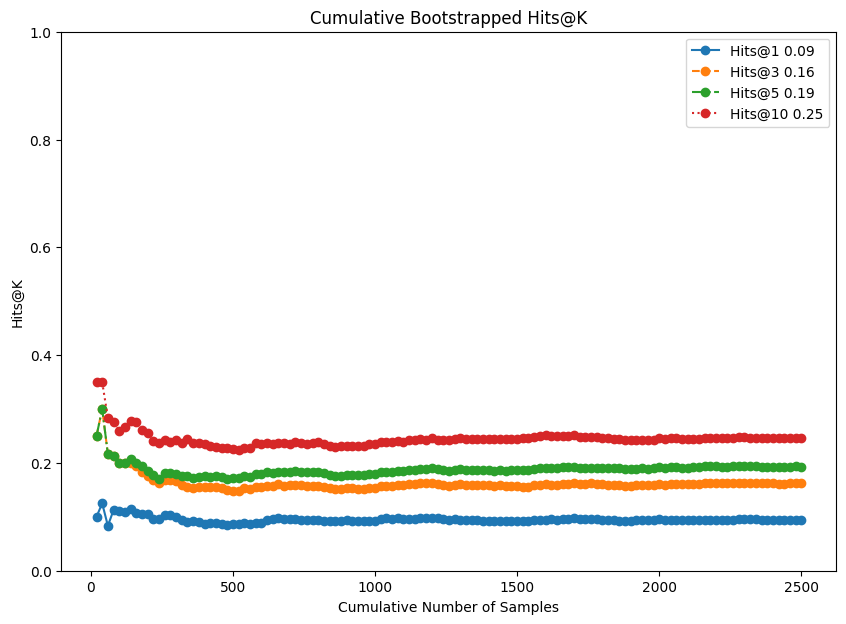

In [64]:
visualize_bootstrapped_hits_at_k(evalute_response_zr_naive)
